<img src='./assumption.png'>

Each dataset consist of same the number of images for fairness </br>
Loss function에는 log를 씌워서 smooth하게 표현한다 </br>
style embedding vector는 1 sphere visualization or PCA(3-dim)으로 표현

In [105]:
import torchvision
from torchvision import models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os, subprocess
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [106]:
!pwd

/home/qkrwnstj/backup/paper_with_kko/contrastive_learning


In [107]:
data_dir = "./data"

In [108]:
dir_lst = os.listdir(data_dir)
dir_lst

['train', 'test']

In [109]:
for dir in dir_lst:
    dir_path = os.listdir(f"./data/{dir}")

    for name in dir_path:
        if name == ".ipynb_checkpoints":
            print(name)
            os.rmdir(f"./data/{dir}/{name}")

In [110]:
IMG_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512), antialias = True),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ])

In [111]:
train_imgfolder = ImageFolder(root="./data/train",
                              transform=IMG_TRANSFORM,
                              target_transform=None
                             )

test_imgfolder = ImageFolder(root="./data/test",
                              transform=IMG_TRANSFORM
                             )

In [112]:
print(len(train_imgfolder.classes))
print(len(test_imgfolder.classes))

126
125


In [113]:
Image.MAX_IMAGE_PIXELS = None

train_dataloader = DataLoader(dataset=train_imgfolder,
							  batch_size = 32,
                              num_workers=os.cpu_count(),
                              shuffle=True,
                              drop_last=True 
                             )

test_dataloader = DataLoader(dataset=test_imgfolder,
							  batch_size = 32,
                              num_workers=os.cpu_count(),
                              shuffle=True,
                              drop_last=True 
                            )

In [114]:
batch_x, batch_y = next(iter(train_dataloader))

print(batch_x.shape, batch_y.shape) # batch, channel, width, height

torch.Size([32, 3, 512, 512]) torch.Size([32])


## image plot

In [115]:
plot_x, plot_y = batch_x[: 6,:,:], batch_y[:6]
plot_x.shape, plot_y.shape

(torch.Size([6, 3, 512, 512]), torch.Size([6]))

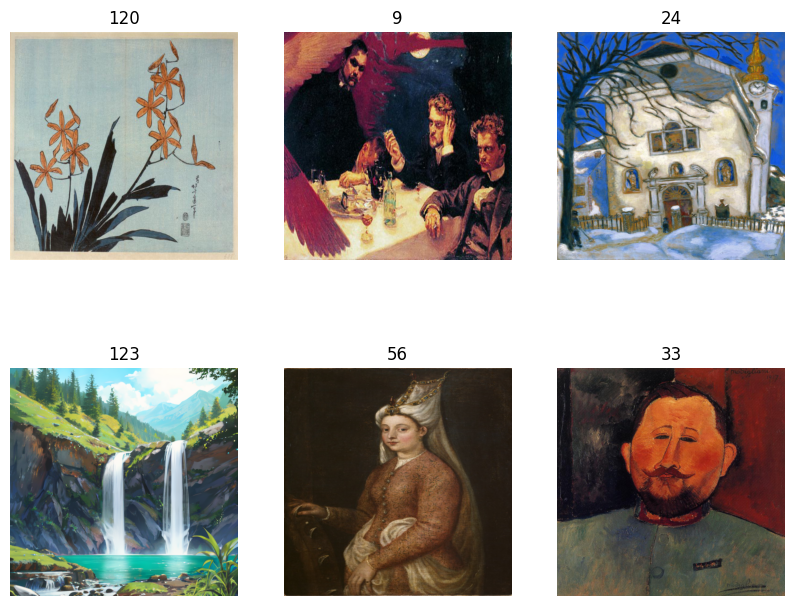

In [116]:
figure = plt.figure(figsize=(10,8))
rows, cols = 2, 3

for i in range(1, rows*cols +1):
    img, label = plot_x[i-1], plot_y[i-1]
    img = (img*0.5 + 0.5)
    img = img.permute(1,2,0)
    
    figure.add_subplot(rows, cols, i)
    plt.title(label.item())
    plt.axis('off')
    plt.imshow(img)

plt.show()

In [117]:
#정규화 된 이미지 확인
plot_x

tensor([[[[ 0.5808,  0.7251,  0.7309,  ...,  0.6566,  0.6587,  0.7129],
          [ 0.6484,  0.8031,  0.8294,  ...,  0.7418,  0.7439,  0.7981],
          [ 0.5707,  0.7086,  0.7123,  ...,  0.6132,  0.6153,  0.6692],
          ...,
          [ 0.8861,  0.8829,  0.8475,  ...,  0.8186,  0.7944,  0.8264],
          [ 0.9001,  0.9425,  0.8853,  ...,  0.8241,  0.8263,  0.8565],
          [ 0.9394,  0.9970,  0.9858,  ...,  0.9463,  0.9498,  0.9800]],

         [[ 0.4140,  0.5705,  0.5970,  ...,  0.5546,  0.5567,  0.6110],
          [ 0.4816,  0.6484,  0.6955,  ...,  0.6398,  0.6419,  0.6962],
          [ 0.4039,  0.5539,  0.5784,  ...,  0.5112,  0.5133,  0.5672],
          ...,
          [ 0.7922,  0.7890,  0.7534,  ...,  0.6853,  0.6611,  0.6930],
          [ 0.8087,  0.8510,  0.7912,  ...,  0.6908,  0.6929,  0.7279],
          [ 0.8733,  0.9383,  0.8936,  ...,  0.7978,  0.8013,  0.8315]],

         [[ 0.2229,  0.3736,  0.3941,  ...,  0.3036,  0.3058,  0.3600],
          [ 0.2905,  0.4516,  

## model

In [118]:
import torch
import torch.nn as nn

from tqdm import tqdm

In [119]:
pre_trained_model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')

In [120]:
new_model = torch.nn.Sequential(*(list(pre_trained_model.children())[:-1]))

In [121]:
class modified_resnet50(nn.Module):
    def __init__(self, new_model):
        super(modified_resnet50,self).__init__()
        self.resnet50 = new_model
        self.fc = nn.Linear(2048, 2048)
        self.cls_fc = nn.Linear(2048,126)
        self.activation = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.resnet50(x)
        x = x.squeeze(2,3)
        style_x = self.activation(self.fc(x))
        x = self.cls_fc(style_x)

        # # of classess, 2048
        return x, style_x     

In [122]:
# model setting
model = modified_resnet50(new_model)


In [150]:
EPOCH = 50
LEARNING_RATE = 1e-3 
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = 0.01)
print("Using device: ",DEVICE)

Using device:  cuda:2


In [124]:
model

modified_resnet50(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

### Model test

In [125]:
test_input = torch.randn((2,3,256,256))
test_output = model(test_input)
print(test_output[0].size())
print(test_output[1].size())
#vector형태로 제공, batch x number of classes | batch x hidden_dim

torch.Size([2, 126])
torch.Size([2, 2048])


### 연산 test

In [126]:
#normalize
#unsqueeze를 통해서 차원 수를 맞춰줘야 한다.
#앞의 차원이 동일해야 한다. 
import numpy as np
import copy
A = torch.tensor([[1,2,3],[4,5,6]], dtype = torch.float32)
print(A.size())

#axis 1을 marginalize !!!!!
B = torch.tensor(torch.norm(A,dim=1))
B = B.unsqueeze(1)
print(B.size())

A/B

torch.Size([2, 3])
torch.Size([2, 1])


/tmp/ipykernel_994013/2225082874.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(torch.norm(A,dim=1))


tensor([[0.2673, 0.5345, 0.8018],
        [0.4558, 0.5698, 0.6838]])

In [127]:
#행렬 곱
A = torch.tensor([[1,2,3],[4,5,6]])
B = torch.tensor([[1,2],[3,4],[5,6]])

A@B

tensor([[22, 28],
        [49, 64]])

## Train

In [128]:
criterion = nn.CrossEntropyLoss()

In [129]:
def loss_fn(class_output, encoded_vector, criterion, label):
    #batch x hidden / batch

    ## Cosine-Similarity calculation
    #batch x 1
    magnitude = torch.norm(encoded_vector, dim = 1).unsqueeze(1)
    
    #batch x hidden : normalized hidden vector 
    norm_first = encoded_vector/(magnitude+1e-5) 
    
    #hidden x batch : transpose of normalized first vector
    second_vector = norm_first.T
    
    #batch x batch / batch x hidden / hidden x batch
    encoded_matrix = (norm_first@second_vector)
    positive_sum, negative_sum = 0, 0

    
    for row_index, row_lst in enumerate(encoded_matrix):
        for col_index, item in enumerate(row_lst):
            #positive
            if not row_index == col_index:
                if label[row_index] == label[col_index]:
                    positive_sum = positive_sum - item
            #negative
                else:
                    negative_sum = negative_sum + item

    cos_sim_loss = (positive_sum + negative_sum)/len(label) 

    ## Cross-Entropy Loss
    if class_output != None:
        CE_loss = criterion(class_output, label)

        loss = cos_sim_loss + 3*CE_loss
    else:
        loss = cos_sim_loss
    return loss 

### Loss test

In [130]:
test_vector = torch.tensor([[0,2,0],[0,4,3],[3,4,0]], dtype = torch.float32)
print(test_vector.size())
test_label = torch.tensor([1,1,0], dtype = torch.float32)
print(test_label.size())

torch.Size([3, 3])
torch.Size([3])


In [131]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

cos_sim(torch.tensor([0,2,0]),torch.tensor([0,2,0]))

1.0

In [132]:
test_norm = torch.norm(test_vector, dim = 1)
print(test_norm)
print(test_vector)

test_vector2 = test_vector/test_norm.unsqueeze(1)
print(test_vector2)

test_matrix = test_vector2@test_vector2.T
print(test_matrix)

tensor([2., 5., 5.])
tensor([[0., 2., 0.],
        [0., 4., 3.],
        [3., 4., 0.]])
tensor([[0.0000, 1.0000, 0.0000],
        [0.0000, 0.8000, 0.6000],
        [0.6000, 0.8000, 0.0000]])
tensor([[1.0000, 0.8000, 0.8000],
        [0.8000, 1.0000, 0.6400],
        [0.8000, 0.6400, 1.0000]])


In [133]:
loss = loss_fn(None, test_vector, criterion, test_label)
print(loss)

tensor(0.4267)


In [154]:
def train(train_loader, model, optimizer, criterion, epoch):
    model.train()
    correct = 0
    total = 0
    
    epoch_loss = []
    for index, (img_data,labels) in enumerate(train_loader):
        img_data, labels = img_data.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        
        class_output, encoded_vector = model(img_data)
        loss = loss_fn(class_output, encoded_vector, criterion, labels)

        _, predicted = torch.max(class_output.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        if index%100==0:
            print(f'train loss : {np.mean(epoch_loss):>7f}, [epoch:{epoch}, iter:{index}]')
            
    accuracy = correct / total
    print(f"TRAIN ACCURACY : {(100*accuracy):>0.1f}% [{correct}/{total}]")
    return np.mean(epoch_loss)

In [155]:
def test(test_loader, model, criterion, epoch):
    model.eval()

    epoch_loss = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for index, (img_data,labels) in enumerate(test_loader):
            img_data, labels = img_data.to(DEVICE), labels.to(DEVICE)
            class_output, encoded_vector = model(img_data)
    
            loss = loss_fn(class_output, encoded_vector, criterion, labels)
            
            _, predicted = torch.max(class_output.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            epoch_loss.append(loss.item())
    
    accuracy = correct / total
    
    print(f"TEST ACCURACY : {(100*accuracy):>0.1f}% [{correct}/{total}]")
    return np.mean(epoch_loss)

In [158]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [157]:
train_loss_lst, test_loss_lst = [], []

model_version = 1


test_best_loss = 100
test_current_loss = 100
early_stop_threshold = 5
early_stop_trigger = 0

model = model.to(DEVICE)

for i in tqdm(range(EPOCH), desc = 'Train'):
    print(f"EPOCH {i+1} \n-------------------------")
    train_loss = train(train_dataloader, model, optimizer, criterion, i+1)
    test_loss = test(test_dataloader, model, criterion, i+1)

    train_loss_lst.append(train_loss)
    test_loss_lst.append(test_loss)

    if test_loss < test_best_loss :
        print("...MODEL SAVE...")
        test_best_loss = test_loss 
        
        if model_version == 0:
            torch.save(model.state_dict(),'contrastive_model_for_style_weight_v1_without_target_style.pth')
        else:
            torch.save(model.state_dict(),'contrastive_model_for_style_weight_v1.pth')
        
    if test_current_loss < test_loss:
        early_stop_trigger += 1 
    else:
        early_stop_trigger = 0 
    test_current_loss  = test_loss 

    print(f'\nEPOCH:{i+1} | train loss : {train_loss}, test loss : {test_loss}\n')
    
    if early_stop_trigger >= early_stop_threshold:
        break
        
print("DONE!")

Train:   0%|                                        | 0/50 [00:00<?, ?it/s]

EPOCH 1 
-------------------------
train loss : 11.226865, [epoch:1, iter:0]
train loss : 11.318390, [epoch:1, iter:100]
train loss : 11.336869, [epoch:1, iter:200]
train loss : 11.430895, [epoch:1, iter:300]
train loss : 11.396022, [epoch:1, iter:400]
train loss : 11.338647, [epoch:1, iter:500]
train loss : 11.305268, [epoch:1, iter:600]
train loss : 11.288257, [epoch:1, iter:700]
train loss : 11.255811, [epoch:1, iter:800]
train loss : 11.236242, [epoch:1, iter:900]
train loss : 11.220235, [epoch:1, iter:1000]
train loss : 11.216605, [epoch:1, iter:1100]
train loss : 11.221741, [epoch:1, iter:1200]
train loss : 11.201191, [epoch:1, iter:1300]
train loss : 11.193670, [epoch:1, iter:1400]
train loss : 11.200017, [epoch:1, iter:1500]
train loss : 11.228982, [epoch:1, iter:1600]
train loss : 11.244114, [epoch:1, iter:1700]
train loss : 11.254458, [epoch:1, iter:1800]


/home/qkrwnstj/anaconda3/envs/qkrwnstj/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train loss : 11.274291, [epoch:1, iter:1900]
train loss : 11.281756, [epoch:1, iter:2000]
train loss : 11.274755, [epoch:1, iter:2100]
train loss : 11.271716, [epoch:1, iter:2200]
train loss : 11.269306, [epoch:1, iter:2300]
train loss : 11.270527, [epoch:1, iter:2400]
train loss : 11.268319, [epoch:1, iter:2500]


/home/qkrwnstj/anaconda3/envs/qkrwnstj/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/qkrwnstj/anaconda3/envs/qkrwnstj/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train loss : 11.266827, [epoch:1, iter:2600]
train loss : 11.274504, [epoch:1, iter:2700]
train loss : 11.266864, [epoch:1, iter:2800]
train loss : 11.266338, [epoch:1, iter:2900]
train loss : 11.257520, [epoch:1, iter:3000]
train loss : 11.253931, [epoch:1, iter:3100]
train loss : 11.255041, [epoch:1, iter:3200]
train loss : 11.252039, [epoch:1, iter:3300]
TRAIN ACCURACY : 10.2% [11021/108160]
TEST ACCURACY : 5.1% [1346/26176]
...MODEL SAVE...


Train:   2%|▌                          | 1/50 [28:27<23:14:04, 1707.03s/it]


EPOCH:1 | train loss : 11.243296989745643, test loss : 13.63057404916852

EPOCH 2 
-------------------------
train loss : 11.385869, [epoch:2, iter:0]
train loss : 11.076747, [epoch:2, iter:100]
train loss : 11.186378, [epoch:2, iter:200]
train loss : 11.198752, [epoch:2, iter:300]
train loss : 11.158562, [epoch:2, iter:400]
train loss : 11.158156, [epoch:2, iter:500]
train loss : 11.169200, [epoch:2, iter:600]


/home/qkrwnstj/anaconda3/envs/qkrwnstj/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train loss : 11.199656, [epoch:2, iter:700]
train loss : 11.218145, [epoch:2, iter:800]
train loss : 11.211667, [epoch:2, iter:900]
train loss : 11.205954, [epoch:2, iter:1000]
train loss : 11.199544, [epoch:2, iter:1100]
train loss : 11.207617, [epoch:2, iter:1200]
train loss : 11.237693, [epoch:2, iter:1300]
train loss : 11.234033, [epoch:2, iter:1400]
train loss : 11.233869, [epoch:2, iter:1500]
train loss : 11.222757, [epoch:2, iter:1600]
train loss : 11.207163, [epoch:2, iter:1700]
train loss : 11.210901, [epoch:2, iter:1800]
train loss : 11.194831, [epoch:2, iter:1900]


/home/qkrwnstj/anaconda3/envs/qkrwnstj/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train loss : 11.185784, [epoch:2, iter:2000]
train loss : 11.179156, [epoch:2, iter:2100]
train loss : 11.187347, [epoch:2, iter:2200]
train loss : 11.182069, [epoch:2, iter:2300]
train loss : 11.193419, [epoch:2, iter:2400]
train loss : 11.188085, [epoch:2, iter:2500]
train loss : 11.178134, [epoch:2, iter:2600]


/home/qkrwnstj/anaconda3/envs/qkrwnstj/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train loss : 11.168291, [epoch:2, iter:2700]
train loss : 11.165330, [epoch:2, iter:2800]
train loss : 11.164313, [epoch:2, iter:2900]
train loss : 11.157670, [epoch:2, iter:3000]
train loss : 11.154325, [epoch:2, iter:3100]
train loss : 11.151694, [epoch:2, iter:3200]


Train:   2%|▌                          | 1/50 [53:06<43:22:32, 3186.79s/it]


KeyboardInterrupt: 

In [148]:
train_loss_lst, test_loss_lst

([12.611266409574881,
  11.639688749144064,
  11.28797799496961,
  11.167867595204235],
 [16.047799116241904,
  13.210659965617733,
  13.373836153585346,
  14.02816419671392])

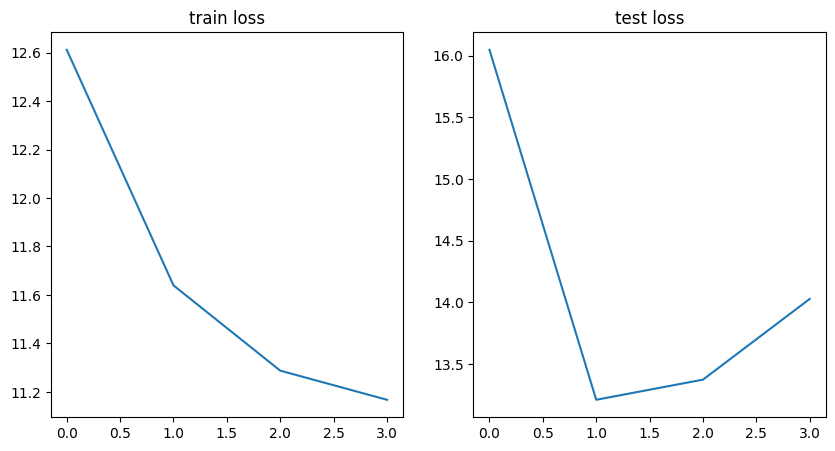

In [149]:
figure = plt.figure(figsize = (10,5))
rows, cols = 1, 2 

title = ['train loss', 'test loss']
values = [train_loss_lst, test_loss_lst]
for i in range(1, rows* cols +1):
    figure.add_subplot(rows,cols,i)
    plt.title(title[i-1])
    plt.plot(values[i-1])

plt.show()

# Inference

In [1086]:
IMG_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512)),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

In [1087]:
def score_fn_inference(target_encoded_vector, inference_target_vector, inference_encoded_vector):
    #batch x hidden / 20 x hidden / 20 x hidden 
    
    #batch x 1
    target_magnitude = torch.norm(target_encoded_vector, dim = 1).unsqueeze(1)
    #20 x 1 
    inference_target_magnitude = torch.norm(inference_target_vector, dim = 1).unsqueeze(1)
    #20 x 1 
    inference_encoded_magnitude = torch.norm(inference_encoded_vector, dim = 1).unsqueeze(1)

    target = target_encoded_vector/target_magnitude
    inference_target = inference_target_vector/inference_target_magnitude
    inference = inference_encoded_vector/inference_encoded_magnitude

    #batch x 20
    target_pair_matrix = target@inference_target.T
    
    #batch x 20
    target_inference_matrix = target@inference.T

    target_pair_score, target_inference_score = torch.mean(target_pair_matrix), torch.mean(target_inference_matrix)
    target_pair_score, target_inference_score = target_pair_score.item(), target_inference_score.item()
    
    return target_pair_score, target_inference_score

In [1088]:
def inference(target_imgs, inference_target_imgs, inference_imgs, model):
    model.eval()
    
    with torch.no_grad():
        target_imgs, inference_target_imgs, inference_imgs= target_imgs.to(DEVICE), inference_target_imgs.to(DEVICE), inference_imgs.to(DEVICE)
        print(target_imgs.size(), inference_target_imgs.size(), inference_imgs.size())
        _, target_encoded_vector = model(target_imgs)
        _, inference_target_vector = model(inference_target_imgs)
        _, inference_encoded_vector = model(inference_imgs)
        
        target_pair_score, target_inference_score = score_fn_inference(target_encoded_vector, 
                                                                       inference_target_vector, 
                                                                       inference_encoded_vector)
        
    return target_pair_score, target_inference_score

In [1089]:
# setting
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

pre_trained_model = models.resnet50(pretrained=True)
new_model = torch.nn.Sequential(*(list(pre_trained_model.children())[:-1]))


class modified_resnet50(nn.Module):
    def __init__(self, new_model):
        super(modified_resnet50,self).__init__()
        self.resnet50 = new_model
        self.fc = nn.Linear(2048, 2048)
        self.cls_fc = nn.Linear(2048,126)
        
    def forward(self, x):
        x = self.resnet50(x)
        x = x.squeeze(2,3)
        style_x = self.fc(x)
        x = self.cls_fc(style_x)

        # # of classess, 2048
        return x, style_x     

model = modified_resnet50(new_model)
model = model.to(DEVICE)
model

/home/qkrwnstj/anaconda3/envs/qkrwnstj/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/qkrwnstj/anaconda3/envs/qkrwnstj/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


modified_resnet50(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [1091]:
model_version = 1

if model_version == 0:
    model.load_state_dict(torch.load('contrastive_model_for_style_weight_v1_without_target_style.pth'))
else:
    model.load_state_dict(torch.load('contrastive_model_for_style_weight_v1.pth'))


In [1092]:
!pwd

/home/qkrwnstj/backup/paper_with_kko/contrastive_learning


In [1093]:
def set_img(basic_path, dir):
    img_lst = os.listdir(basic_path + dir)
    imgs = []
    for img in img_lst:
        if img == '.ipynb_checkpoints':
            continue
        img = PIL.Image.open(basic_path+dir+'/'+img)
        img = IMG_TRANSFORM(img).unsqueeze(0)
        imgs.append(img)
    
    return torch.cat(imgs,0)

In [1100]:
#load img
import PIL
import torchvision.transforms as transforms

basic_target_path = './inference_data/target/'    # target style 
target_dir = 'anime' # realistic | anime | mid | romanticism

basic_inference_target_path = './inference_data/target_inference/'   # style reference image 
target_inference_dir = 'mid' # realistic | anime | mid

basic_inference_path = './inference_data/inference/'    # auxiliary image 
inference_dir = 'fashion_style' # fashion_style | art_style | digital_person3 | mid | mid_background | realistic | illustarion_style
# digital_person | digital_person2 | digital_anime_person

target_imgs = set_img(basic_target_path, target_dir)
inference_target_imgs = set_img(basic_inference_target_path, target_inference_dir)
inference_imgs = set_img(basic_inference_path, inference_dir)


#inference
target_pair_score, target_inference_score = inference(target_imgs, inference_target_imgs, inference_imgs, model)
print(f'target : {target_dir}\ntarget_pair_score({target_inference_dir}): {target_pair_score}\ntarget_inference_score({inference_dir}): {target_inference_score}')

torch.Size([56, 3, 512, 512]) torch.Size([20, 3, 512, 512]) torch.Size([20, 3, 512, 512])
target : anime
target_pair_score(mid): 0.6869869828224182
target_inference_score(fashion_style): 0.3121492266654968


<strong> 1에 너무 가까운 점수면 target style이므로 추천 x </strong></br>
<strong> 0에 너무 가까운 점수면 도움이 되는 정보가 적으므로 추천 x </strong></br>
<strong> 0.2~0.5 => 추천 </strong></br></br>
## **_style에 binding을 할 때 도움을 주는 정보를 크게 2가지로 분류 : content(이미지의 내용) & style(colortone, texture, hue etc)_**
</br>
<strong>이 model의 경우, style에 대한 score이다. 즉, content에 대해서도 적절한 정보를 담은 이미지를 제공해야 결론적으로 성능이 올라간다. </strong>
</br>
style에서 점수가 낮아도, content면에서 적절한 정보를 제공한다면 어느 정도의 성능을 유지하거나 끌어올릴 수 있다.
<img src='./image.png'>

In [1049]:
def pca_image_to_vector(target_imgs, inference_target_imgs, inference_imgs, model):
    model.eval()
    
    with torch.no_grad():
        target_imgs, inference_target_imgs, inference_imgs= target_imgs.to(DEVICE), inference_target_imgs.to(DEVICE), inference_imgs.to(DEVICE)
        print(target_imgs.size(), inference_target_imgs.size(), inference_imgs.size())
        _, target_encoded_vector = model(target_imgs)
        _, inference_target_vector = model(inference_target_imgs)
        _, inference_encoded_vector = model(inference_imgs)
        print(target_encoded_vector.size(), inference_target_vector.size(), inference_encoded_vector.size())
    return target_encoded_vector, inference_target_vector, inference_encoded_vector

In [1050]:
target_vector, inference_target_vector, inference_vector = pca_image_to_vector(target_imgs, inference_target_imgs, inference_imgs, model)

torch.Size([60, 3, 512, 512]) torch.Size([20, 3, 512, 512]) torch.Size([20, 3, 512, 512])
torch.Size([60, 2048]) torch.Size([20, 2048]) torch.Size([20, 2048])


In [1051]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

target_vector, inference_target_vector, inference_vector = target_vector.cpu().numpy(), inference_target_vector.cpu().numpy(), inference_vector.cpu().numpy()


In [1052]:
df_target = pd.DataFrame(data= target_vector)
df_target_inference = pd.DataFrame(data = inference_target_vector)
df_inference = pd.DataFrame(data = inference_vector)

In [1053]:
target_len = len(df_target)
target_inference_len = len(df_target_inference)
inference_len = len(df_inference)
df_target.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.131220,1.023023,0.159844,0.285146,-0.155361,-0.271858,0.094085,0.086845,-0.070502,0.276793,...,0.341284,0.071527,0.141085,-0.406435,0.879291,0.219794,-0.540531,-0.548032,-0.060894,-0.656368
1,0.109258,0.150204,-0.064367,0.016179,0.038128,-0.056231,-0.076733,0.081313,-0.078665,0.098224,...,-0.050077,0.153471,-0.129331,-0.032645,0.036355,0.036763,-0.152746,-0.147020,0.019292,-0.049157
2,0.142184,0.864278,0.127581,0.236667,-0.151527,-0.257130,0.038690,0.058620,0.059770,0.354507,...,0.290630,0.037039,0.149377,-0.218518,0.723246,0.178673,-0.492098,-0.503425,0.002290,-0.496796
3,-0.043229,0.714284,0.117848,0.174156,-0.114111,-0.251807,0.213460,0.114864,-0.126341,0.154718,...,0.283867,0.124409,0.145009,-0.424866,0.737973,0.052930,-0.281328,-0.378323,-0.132750,-0.623024
4,0.187101,0.669814,-0.046878,0.131609,-0.035144,-0.043612,-0.022188,0.039634,0.179122,0.307929,...,0.180783,0.024575,0.033610,-0.198318,0.546944,0.056468,-0.262420,-0.373543,-0.053837,-0.389454


In [1054]:
total_pd = pd.concat([df_target, df_target_inference,df_inference])

In [1055]:
total_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.131220,1.023023,0.159844,0.285146,-0.155361,-0.271858,0.094085,0.086845,-0.070502,0.276793,...,0.341284,0.071527,0.141085,-0.406435,0.879291,0.219794,-0.540531,-0.548032,-0.060894,-0.656368
1,0.109258,0.150204,-0.064367,0.016179,0.038128,-0.056231,-0.076733,0.081313,-0.078665,0.098224,...,-0.050077,0.153471,-0.129331,-0.032645,0.036355,0.036763,-0.152746,-0.147020,0.019292,-0.049157
2,0.142184,0.864278,0.127581,0.236667,-0.151527,-0.257130,0.038690,0.058620,0.059770,0.354507,...,0.290630,0.037039,0.149377,-0.218518,0.723246,0.178673,-0.492098,-0.503425,0.002290,-0.496796
3,-0.043229,0.714284,0.117848,0.174156,-0.114111,-0.251807,0.213460,0.114864,-0.126341,0.154718,...,0.283867,0.124409,0.145009,-0.424866,0.737973,0.052930,-0.281328,-0.378323,-0.132750,-0.623024
4,0.187101,0.669814,-0.046878,0.131609,-0.035144,-0.043612,-0.022188,0.039634,0.179122,0.307929,...,0.180783,0.024575,0.033610,-0.198318,0.546944,0.056468,-0.262420,-0.373543,-0.053837,-0.389454


In [1056]:
#total_pd.columns = total_pd.columns.astype(str)
scaler = StandardScaler()

scaler.fit(total_pd)
scaled_data= scaler.transform(total_pd)

scaled_df = pd.DataFrame(scaled_data, columns = total_pd.columns)

scaled_df['label'] = -1
scaled_df.loc[scaled_df.index < target_len,'label'] = 0
scaled_df.loc[target_len <= scaled_df.index,'label'] = 1
scaled_df.loc[target_len+target_inference_len <= scaled_df.index , 'label'] = 2
scaled_df['label'].head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [1057]:
from sklearn.decomposition import PCA

pca = PCA(n_components =2)
pca.fit(scaled_df.iloc[:,:-1])

df_pca = pca.transform(scaled_df.iloc[:,:-1])
df_pca = pd.DataFrame(df_pca, columns = ['Component 0','Component 1'])

df_pca

,Component 0,Component 1
0,-39.092697,-29.881952
1,0.209930,33.154747
2,-26.386322,-34.106956
3,-35.791138,-1.422343
4,-11.654102,-14.366641
...,...,...
95,32.608276,24.897533
96,38.282684,-2.657804
97,39.458115,29.408201
98,32.691658,25.532894


In [1058]:
print(pca.explained_variance_ratio_)

[0.51875854 0.19151548]


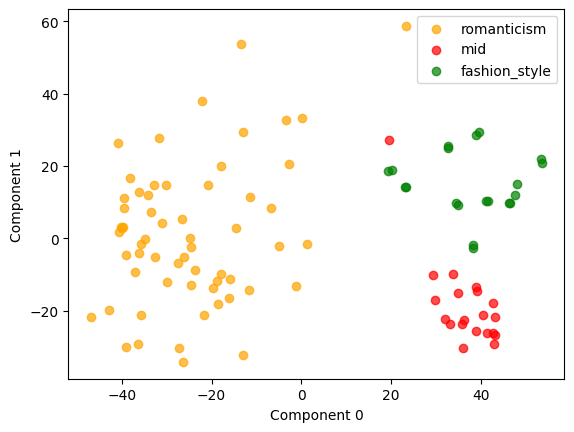

In [1059]:
import matplotlib.pyplot as plt

# class target 정보 불러오기 
df_pca['label'] = scaled_df['label']

# target 별 분리
df_pca_0 = df_pca[df_pca['label'] == 0]
df_pca_1 = df_pca[df_pca['label'] == 1]
df_pca_2 = df_pca[df_pca['label'] == 2]

# target 별 시각화
plt.scatter(df_pca_0['Component 0'], df_pca_0['Component 1'], color = 'orange', alpha = 0.7, label = target_dir)
plt.scatter(df_pca_1['Component 0'], df_pca_1['Component 1'], color = 'red', alpha = 0.7, label = target_inference_dir)
plt.scatter(df_pca_2['Component 0'], df_pca_2['Component 1'], color = 'green', alpha = 0.7, label = inference_dir)

plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.legend()
plt.show()

In [1060]:
from sklearn.decomposition import PCA

pca = PCA(n_components =3)
pca.fit(scaled_df.iloc[:,:-1])

df_pca = pca.transform(scaled_df.iloc[:,:-1])
df_pca = pd.DataFrame(df_pca, columns = ['Component 0','Component 1','Component 2'])

df_pca

,Component 0,Component 1,Component 2
0,-39.092697,-29.881962,2.543844
1,0.209929,33.154751,1.951467
2,-26.386322,-34.106968,4.346005
3,-35.791138,-1.422339,-7.443399
4,-11.654101,-14.366656,21.736731
...,...,...,...
95,32.608273,24.897537,1.506915
96,38.282677,-2.657802,-3.999517
97,39.458111,29.408199,4.086814
98,32.691658,25.532898,0.949595


In [1061]:
print(pca.explained_variance_ratio_)

[0.5187585  0.19151558 0.1076079 ]


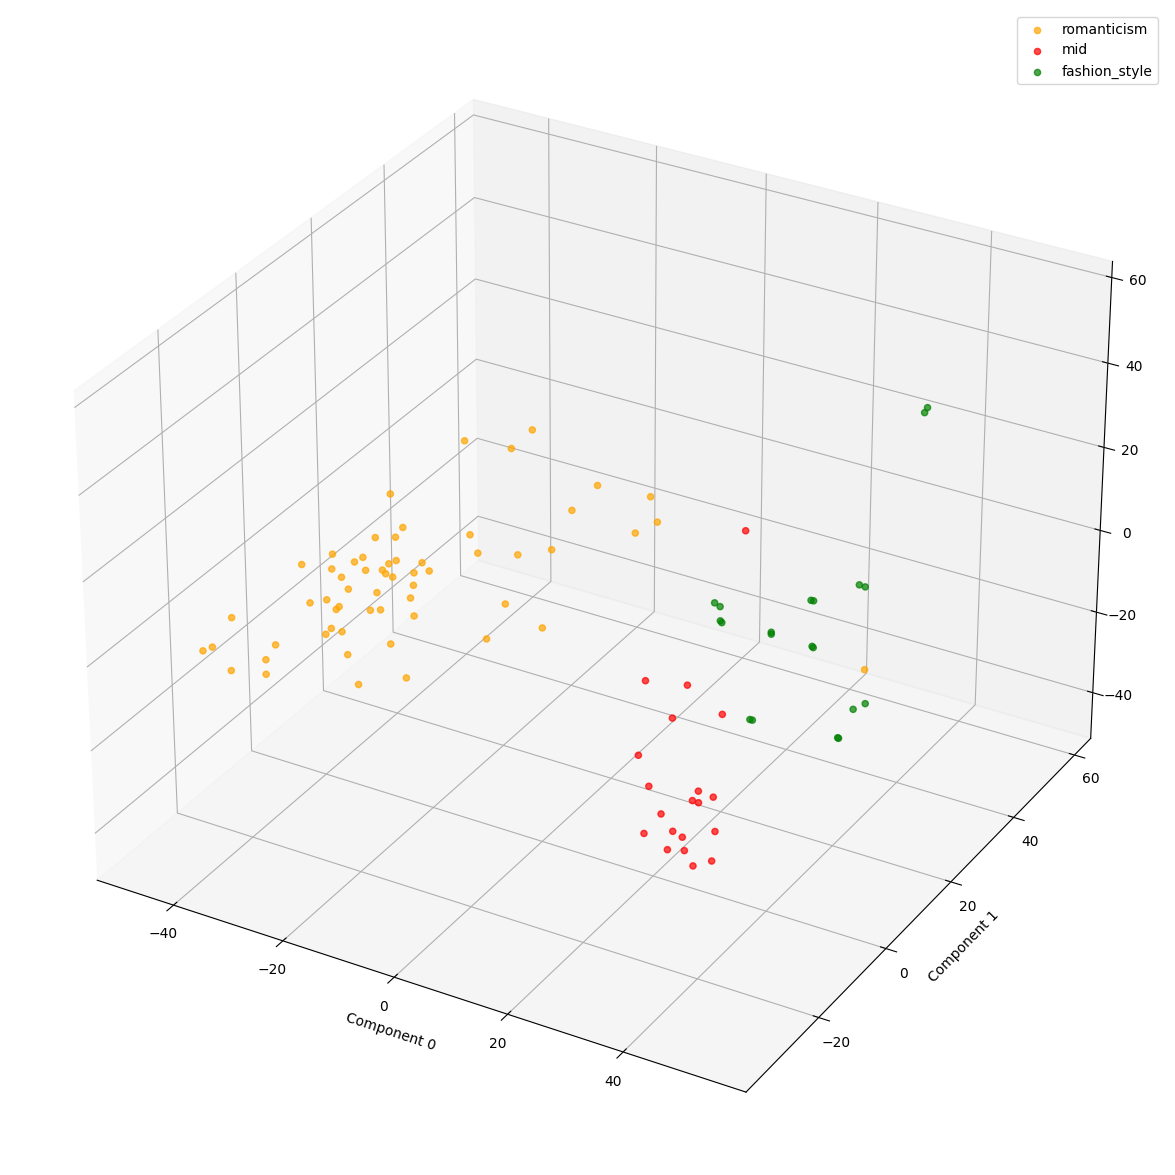

In [1062]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

# class target 정보 불러오기 
df_pca['label'] = scaled_df['label']

# target 별 분리
df_pca_0 = df_pca[df_pca['label'] == 0]
df_pca_1 = df_pca[df_pca['label'] == 1]
df_pca_2 = df_pca[df_pca['label'] == 2]

# target 별 시각화
ax.scatter(df_pca_0['Component 0'], df_pca_0['Component 1'], df_pca_0['Component 2'], color = 'orange', alpha = 0.7, label = target_dir)
ax.scatter(df_pca_1['Component 0'], df_pca_1['Component 1'], df_pca_1['Component 2'], color = 'red', alpha = 0.7, label = target_inference_dir)
ax.scatter(df_pca_2['Component 0'], df_pca_2['Component 1'], df_pca_2['Component 2'],color = 'green', alpha = 0.7, label = inference_dir)

plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.legend()
plt.show()